In [2]:
# Path de trabajo
WORK_DIR = '/home/dipa/proyectos/7506-Organizacion-de-Datos/tp_2'

In [4]:
import sys
sys.path.append('/home/dipa/proyectos/7506-Organizacion-de-Datos/tp_2')



import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.transform import transform_data
from lib import prepare_data
from lib import model_data

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

### Load data

In [5]:
### Se carga el file correspondiente
train = 'data/Entrenamieto_ECI_2020.csv'


df = prepare_data.load(os.path.join(WORK_DIR, train))
df['Target'] = np.where(df['Stage'] != 'Closed Lost', 1, 0)

In [6]:
df.loc[df['Opportunity_ID'] == 8,]

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Target
8,24353,Japan,NaN,True,False,False,False,False,Bureaucratic_Code_5,2015-04-20,...,2016-01-01,NaT,0,JPY,15600.0,JPY,470400.0,Closed Lost,Prod_Category_A_None,0
9,24355,Japan,NaN,True,False,False,False,False,Bureaucratic_Code_5,2015-04-20,...,2016-01-01,NaT,0,JPY,4400.0,JPY,470400.0,Closed Lost,Prod_Category_A_None,0
10,24356,Japan,NaN,True,False,False,False,False,Bureaucratic_Code_5,2015-04-20,...,2016-01-01,NaT,0,JPY,6200.0,JPY,470400.0,Closed Lost,Prod_Category_A_None,0
11,24357,Japan,NaN,True,False,False,False,False,Bureaucratic_Code_5,2015-04-20,...,2016-01-01,NaT,0,JPY,140000.0,JPY,470400.0,Closed Lost,Prod_Category_A_None,0
12,24358,Japan,NaN,True,False,False,False,False,Bureaucratic_Code_5,2015-04-20,...,2016-01-01,NaT,0,JPY,304200.0,JPY,470400.0,Closed Lost,Prod_Category_A_None,0


# Prepare data


## Pre-processing: antes de agrupar

### Variables monto:
        * pasar todo a dolares (ya incluido en la carga)
        * completar valores 0/NaN de Total_Amount con : TRF * ASP_(converted) | mediana 

#### completar valores 0/NaN de Total_Amount con : TRF * ASP_(converted) | mediana 

In [7]:
# check cuantos valores con cero hay
df.loc[df['Total_Amount'] == 0,].shape[0] # 52

# check cuantos valores con cero hay
df['Total_Amount'].isna().sum() # 59

59

In [8]:
# reemplazo nan por cero
df['Total_Amount'].replace(np.nan, 0,  inplace=True)
df.loc[df['Total_Amount'] == 0,].shape[0] # 111

111

In [9]:
def completed_cero_Total_Amounts(df):
    

    df['price_trf'] = df['ASP_(converted)'] * df['TRF'] * 1000000
    # reemplazo nan por cero
    df['price_trf'].replace(np.nan, 0,  inplace=True)
    
    # asigno a cada product_name la mediana
    df['product_median_amount'] = df.groupby('Product_Name')['Total_Amount'].transform('median')
    # reemplazo nan por cero
    df['product_median_amount'].replace(np.nan, 0,  inplace=True)

    
    rows = []
    
    for idx, row in df.iterrows():
        if row['Total_Amount'] == 0:
            if row['price_trf'] != 0:
                rows.append(row['price_trf'])
            else:
                rows.append(row['product_median_amount'])
        else:
            rows.append(row['Total_Amount'])
    
    # elimino columnas
    df.drop(['price_trf', 'product_median_amount'], axis=1, inplace=True)
    
            
    return pd.Series(rows)
    

In [10]:
df['Total_Amount'] = completed_cero_Total_Amounts(df)

In [11]:
df.loc[df['Total_Amount'] == 0,].shape[0]  # me queda un unico registro sin completar
df.loc[df['Total_Amount'] == 0,] # queda un unico registro con valor cero que se puede completar con Total_Taxable_Amount

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Bureaucratic_Code,Account_Created_Date,...,Delivery_Year,Actual_Delivery_Date,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage,Prod_Category_A,Target
16300,27973,EMEA,Macedonia,True,False,True,False,False,Bureaucratic_Code_5,2015-06-22,...,2016-01-01,NaT,1,EUR,0.0,EUR,549450.0,Closed Lost,Prod_Category_A_None,0


### Varable region

In [12]:
df.Region.value_counts()
df.Region.isna().sum() # no hay valores faltantes

0

In [13]:
# pero si hay valores ambiguos, un mismo territorio esta asignado a 2 regiones diferentes (ver tp_1)
# hay territorios con mas de una region?
df.groupby('Territory').agg({'Region':'nunique'}).max()


Region    2
dtype: int64

In [14]:
# desamabiguo
# Actualizo todas a la Región de mayor cantidad de Oportunidades
df.loc[df.Territory=='Jordan','Region'] = 'Middle East'
df.loc[df.Territory=='KSA','Region'] = 'Middle East'
df.loc[df.Territory=='Kuwait','Region'] = 'Middle East'
df.loc[df.Territory=='SE America','Region'] = 'Americas'
df.loc[df.Territory=='SW America','Region'] = 'Americas'
df.loc[df.Territory=='UAE (Dubai)','Region'] = 'Middle East'

In [15]:
# compruebo
df.groupby('Territory').agg({'Region':'nunique'}).max()

Region    1
dtype: int64

### Variable Planned_Delivery_End_Date

In [16]:
# valores Nan de la variable
df.loc[df.Planned_Delivery_End_Date.isna(),'Planned_Delivery_End_Date'].shape[0]

75

In [17]:
# completo con la variable Month
df['Planned_Delivery_End_Date'] = df.apply(lambda x: x['Month'] if pd.isnull(x['Planned_Delivery_End_Date'])\
                                           else x['Planned_Delivery_End_Date'], axis=1) 


In [18]:
# compruebo
df.loc[df.Planned_Delivery_End_Date.isna(),'Planned_Delivery_End_Date'].shape[0]

0

### Variables booleanas

In [19]:
features_bool = ['Pricing, Delivery_Terms_Approved', 'Pricing, Delivery_Terms_Quote_Appr',
                    'Bureaucratic_Code_0_Approval',
                    'Bureaucratic_Code_0_Approved','Submitted_for_Approval']


for col in features_bool:
    df[col] = df[col].map(lambda x: 0 if x == False else 1)




In [20]:
df['Pricing, Delivery_Terms_Approved']
df['Bureaucratic_Code_0_Approval'].value_counts()

0    8889
1    8058
Name: Bureaucratic_Code_0_Approval, dtype: int64

In [21]:
# paso a formato de 1-12
df['Month'] = df['Month'].dt.month

In [22]:
# check
df.groupby('Opportunity_ID')['Month'].max()


Opportunity_ID
0         5
1         1
2         1
3         2
4         2
         ..
12799     4
12800    10
12801     4
12802     4
12803     7
Name: Month, Length: 9841, dtype: int64

## Agrupamos por oportunidad

In [45]:
gruped = df.groupby('Opportunity_ID').agg(Total_Taxable_Amount = ('Total_Taxable_Amount', 'first'),\
                                                 Total_Amount_sum =('Total_Amount', 'sum'),\
                                                 Region=('Region','first'),\
                                                 Target = ('Target', 'first'),\
                                                 Opportunity_Created_Date =('Opportunity_Created_Date','first'),\
                                                 Account_Created_Date = ('Account_Created_Date','first'),\
                                                 Planned_Delivery_End_Date=('Planned_Delivery_End_Date','max'),\
                                                 Pricing_Delivery_Terms_Approved = ('Pricing, Delivery_Terms_Approved','first'),\
                                                 Pricing_Delivery_Terms_Quote_Appr = ('Pricing, Delivery_Terms_Quote_Appr','first'),\
                                                 Bureaucratic_Code_0_Approval= ('Bureaucratic_Code_0_Approval','first'),\
                                                 Bureaucratic_Code_0_Approved = ('Bureaucratic_Code_0_Approved','first'),\
                                                 Submitted_for_Approval = ('Submitted_for_Approval','first'),\
                                                 Month = ('Month', 'max'),\
                                                 Product_Family=('Product_Family', lambda x: list(x))).reset_index()

In [21]:
# agrego variable target
#df['TARGET'] = np.where(df['Stage'] != 'Closed Lost', 1, 0)

In [22]:
#gruped['Target'] = df.groupby('Opportunity_ID').agg(Target = ('TARGET', 'first'))


In [24]:
gruped.columns
gruped.shape

(9841, 15)

In [25]:
# Se agrega una variable random booleana como control para la seleccion de variables 
gruped['random_feature'] = np.random.randint(2, size=9841)

## Post-processing: despues de  agrupar

### Varable Total_Taxable_Amount

In [26]:
gruped.loc[gruped['Total_Taxable_Amount'] == 0,].shape[0] # 734 valores 
gruped['Total_Taxable_Amount'].isna().sum() # no hay vaores NaN 
# reemplazo nan por cero
gruped['Total_Taxable_Amount'].replace(np.nan, 0,  inplace=True)
# compruebo
gruped.loc[gruped['Total_Taxable_Amount'] == 0,].shape[0] # 734 valores con valor cero

734

In [27]:
# completo los valores cero por la suma de Total_Amount
gruped['Total_Taxable_Amount'] = gruped.apply(lambda x: x['Total_Amount_sum'] if x['Total_Taxable_Amount'] == 0 \
                                                                        else x['Total_Taxable_Amount'], axis=1)

gruped.loc[gruped['Total_Taxable_Amount'] == 0,].shape[0]

0

### Sanity checks Variables Temporales

In [28]:
# anios entre 2013-2018 de todas las columnas fechas de interes
bad_years = []
for column_year in ['Opportunity_Created_Date', 'Account_Created_Date', 'Planned_Delivery_End_Date']:
    #print(column_year)
    for year in gruped[column_year].dt.year:
        if (year > 2021) | (year < 2013) :
            bad_years.append((year, column_year ))
bad_years



[(2208, 'Planned_Delivery_End_Date')]

In [29]:
gruped.loc[gruped['Planned_Delivery_End_Date'].dt.year == 2208,]
# remuevo dato erroneo
gruped= gruped[~(gruped['Planned_Delivery_End_Date'].dt.year == 2208)]

In [30]:
# Account_Created_Date <= Planned_Delivery_End_Date, entrega del producto posterior o igual a la creacion de la cuenta
condition_2 = (gruped['Opportunity_Created_Date'] <= gruped['Planned_Delivery_End_Date'])
print(9840 -condition_2.sum()) # 50 
gruped['Planned_Delivery_End_Date'] = gruped.apply(lambda x: x['Opportunity_Created_Date'] if (x['Opportunity_Created_Date'] > x['Planned_Delivery_End_Date']) else x['Planned_Delivery_End_Date'], axis=1) 
condition_2 = (gruped['Opportunity_Created_Date'] <= gruped['Planned_Delivery_End_Date'])
print(9840 -condition_2.sum()) # 0

# Account_Created_Date <= Opportunity_Created_Date, creacion de la cuenta anterior o mismo tiempo que la oportunidad
condition_3 = (gruped['Account_Created_Date'] <= gruped['Opportunity_Created_Date'])
print(9840 - condition_3.sum())  # 75
gruped['Account_Created_Date'] = gruped.apply(lambda x: x['Opportunity_Created_Date'] if (x['Opportunity_Created_Date'] < x['Account_Created_Date']) else x['Account_Created_Date'], axis=1) 
condition_3 = (gruped['Account_Created_Date'] <= gruped['Opportunity_Created_Date'])
print(9840 - condition_3.sum())  # 0

50
0
75
0


## Feature Engineering

### Creacion de Variables

### Antiguedad de la cuenta

In [31]:
# creo la nueva variable antiguedad de la cuenta (meses)
gruped['antiguedad_cuenta'] = round((gruped['Opportunity_Created_Date'] -\
                                     gruped['Account_Created_Date']).dt.days / 30, 2)

### Tiempo de Entrega Maximo

In [32]:
gruped['tiempo_entrega_max'] = (gruped['Planned_Delivery_End_Date'] -\
                                gruped['Opportunity_Created_Date']).dt.days

print(gruped[gruped['tiempo_entrega_max'] < 0].shape[0]) 
print(gruped[gruped['tiempo_entrega_max'] == 0].shape[0]) # 80 valores con cero


0
80


In [ ]:
# target Encoding

def traget_encoding()

### Product Family

(viene de la notebook explore_data)

In [33]:
gruped_family_product = df.groupby('Product_Family')\
                                .agg({'Target':'mean',
                                      'Opportunity_ID': 'nunique'})

In [37]:

code_map = dict()    # guarda el mapeo entre valores origibales y encoded


smooth = 10   # cantidad de casos que considero como valido

n = gruped_family_product['Opportunity_ID']

global_mu =  gruped_family_product['Target'].mean()  # promedio p tasa de exito de las familias


mu = gruped_family_product['Target']

mu_smoothed = (n * mu + smooth * global_mu) / (n + smooth)


code_map = mu_smoothed.to_dict()


In [39]:
helper = gruped.assign(Product_Family_Mean=[[code_map[k] for k in row if code_map.get(k)]\
                                            for row in gruped['Product_Family']])

helper = gruped.assign(Product_Family_Mean=[[code_map[k] for k in row if code_map.get(k) else \
                                            for row in gruped['Product_Family']])

helper['Product_Family_Mean_sin_duplicados'] = helper['Product_Family_Mean']\
                                            .map(lambda x: list(dict.fromkeys(x)))

In [192]:
helper

,Opportunity_ID,Total_Taxable_Amount,Total_Amount_sum,Region,Target,Opportunity_Created_Date,Account_Created_Date,Planned_Delivery_End_Date,Pricing_Delivery_Terms_Approved,Pricing_Delivery_Terms_Quote_Appr,...,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Month,Product_Family,random_feature,antiguedad_cuenta,tiempo_entrega_max,Product_Family_Mean,Product_Family_Mean_sin_duplicados,Product_Family_encoded
0,0,5272800.00,5272800.00,EMEA,0,2015-12-07,2015-06-16,2016-06-30,1,1,...,1,0,5,[Product_Family_77],0,5.80,206,[0.48959230583554847],[0.48959230583554847],0.489592
1,1,48230.00,48230.00,EMEA,1,2015-12-07,2015-06-16,2016-01-20,0,0,...,0,0,1,[Product_Family_77],1,5.80,44,[0.48959230583554847],[0.48959230583554847],0.489592
2,2,83865.60,83865.60,Americas,1,2015-12-08,2015-04-21,2016-01-25,0,0,...,0,0,1,[Product_Family_81],1,7.70,48,[0.7422486260683915],[0.7422486260683915],0.742249
3,3,7421881.50,7421881.50,Americas,0,2015-12-08,2013-07-27,2018-03-31,0,1,...,0,0,2,[Product_Family_209],1,28.80,844,[0.2580788017886773],[0.2580788017886773],0.258079
4,4,13357192.50,13357192.50,Americas,0,2015-12-08,2013-07-27,2018-02-28,0,1,...,0,0,2,[Product_Family_209],1,28.80,813,[0.2580788017886773],[0.2580788017886773],0.258079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,12799,401700.00,401700.00,EMEA,1,2015-12-04,2013-07-27,2016-04-21,1,1,...,0,0,4,[Product_Family_77],1,28.67,139,[0.48959230583554847],[0.48959230583554847],0.311241
9837,12800,21332500.00,21332500.00,Americas,0,2015-12-04,2014-06-16,2016-12-30,0,1,...,0,0,10,"[Product_Family_164, Product_Family_158]",1,17.87,392,"[0.30048219020958444, 0.32199988778805594]","[0.30048219020958444, 0.32199988778805594]",0.569936
9838,12801,299715.00,299715.00,EMEA,1,2015-12-04,2015-12-04,2016-04-08,1,1,...,1,0,4,"[Product_Family_85, Product_Family_85, Product...",1,0.00,126,"[0.569935529749754, 0.569935529749754, 0.56993...",[0.569935529749754],0.322000
9839,12802,2346796.88,2346796.88,Americas,0,2015-12-05,2015-10-20,2016-04-29,1,1,...,1,0,4,[Product_Family_158],1,1.53,146,[0.32199988778805594],[0.32199988778805594],0.300482


In [41]:
gruped['Product_Family'] = helper['Product_Family_Mean_sin_duplicados'].map(lambda x: sum(x) / len(x))


### training y test set


In [239]:
from sklearn.model_selection import train_test_split

In [257]:
helper = gruped.copy()

In [258]:
helper.columns

Index(['Opportunity_ID', 'Total_Taxable_Amount', 'Total_Amount_sum', 'Region',
       'Target', 'Opportunity_Created_Date', 'Account_Created_Date',
       'Planned_Delivery_End_Date', 'Pricing_Delivery_Terms_Approved',
       'Pricing_Delivery_Terms_Quote_Appr', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval', 'Month',
       'Product_Family', 'random_feature', 'antiguedad_cuenta',
       'tiempo_entrega_max'],
      dtype='object')

In [259]:
#helper = helper.loc[:, ['Opportunity_ID','Total_Taxable_Amount', 'Region','antiguedad_cuenta', 'tiempo_entrega_max', 'Target','Pricing_Delivery_Terms_Approved', 'Pricing_Delivery_Terms_Quote_Appr',
#                    'Bureaucratic_Code_0_Approval',
#                    'Bureaucratic_Code_0_Approved','Submitted_for_Approval', 'Month', 'random_feature']]
#helper.columns

helper = helper.loc[:, ['Opportunity_ID','Total_Taxable_Amount', 'Region',\
                        'antiguedad_cuenta', 'tiempo_entrega_max', 'Pricing_Delivery_Terms_Approved',\
                        'Pricing_Delivery_Terms_Quote_Appr',
                        'Bureaucratic_Code_0_Approval',
                        'Bureaucratic_Code_0_Approved','Submitted_for_Approval', 'Month', 'Product_Family','Target','random_feature']]
helper.columns

Index(['Opportunity_ID', 'Total_Taxable_Amount', 'Region', 'antiguedad_cuenta',
       'tiempo_entrega_max', 'Pricing_Delivery_Terms_Approved',
       'Pricing_Delivery_Terms_Quote_Appr', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval', 'Month',
       'Product_Family', 'Target', 'random_feature'],
      dtype='object')

In [260]:
X = helper.copy()

In [261]:
X

,Opportunity_ID,Total_Taxable_Amount,Region,antiguedad_cuenta,tiempo_entrega_max,Pricing_Delivery_Terms_Approved,Pricing_Delivery_Terms_Quote_Appr,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Month,Product_Family,Target,random_feature
0,0,5272800.00,EMEA,5.80,206,1,1,1,1,0,5,0.489592,0,0
1,1,48230.00,EMEA,5.80,44,0,0,0,0,0,1,0.489592,1,1
2,2,83865.60,Americas,7.70,48,0,0,0,0,0,1,0.742249,1,1
3,3,7421881.50,Americas,28.80,844,0,1,1,0,0,2,0.258079,0,1
4,4,13357192.50,Americas,28.80,813,0,1,1,0,0,2,0.258079,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,12799,401700.00,EMEA,28.67,139,1,1,0,0,0,4,0.489592,1,1
9837,12800,21332500.00,Americas,17.87,392,0,1,0,0,0,10,0.311241,0,1
9838,12801,299715.00,EMEA,0.00,126,1,1,1,1,0,4,0.569936,1,1
9839,12802,2346796.88,Americas,1.53,146,1,1,1,1,0,4,0.322000,0,1


In [262]:
X.to_csv('/home/dipa/proyectos/7506-Organizacion-de-Datos/tp_2/notebooks/feature_sample_test.csv')

In [263]:

X = helper.drop(['Opportunity_ID','Target'], axis=1)
y = helper[['Target']].values.ravel()

In [264]:
X.head()

,Total_Taxable_Amount,Region,antiguedad_cuenta,tiempo_entrega_max,Pricing_Delivery_Terms_Approved,Pricing_Delivery_Terms_Quote_Appr,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Submitted_for_Approval,Month,Product_Family,random_feature
0,5272800.0,EMEA,5.8,206,1,1,1,1,0,5,0.489592,0
1,48230.0,EMEA,5.8,44,0,0,0,0,0,1,0.489592,1
2,83865.6,Americas,7.7,48,0,0,0,0,0,1,0.742249,1
3,7421881.5,Americas,28.8,844,0,1,1,0,0,2,0.258079,1
4,13357192.5,Americas,28.8,813,0,1,1,0,0,2,0.258079,1


In [265]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [266]:
X_train.columns
y_train

X_test.columns

Index(['Total_Taxable_Amount', 'Region', 'antiguedad_cuenta',
       'tiempo_entrega_max', 'Pricing_Delivery_Terms_Approved',
       'Pricing_Delivery_Terms_Quote_Appr', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval', 'Month',
       'Product_Family', 'random_feature'],
      dtype='object')

### Seleccion de Features

In [267]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.preprocessing import FunctionTransformer
Log10 = FunctionTransformer(np.log10, validate=True)

In [ ]:
# Modelo Lineal

#from sklearn.preprocessing import FunctionTransformer
#Log10 = FunctionTransformer(np.log10, validate=True)


#ct = ColumnTransformer(
#    [("total_Taxable_Amount", log10, [1])])


#pipeline = Pipeline([
#    ('ct', ct),
#    ('LgR', LogisticRegression())
#])


#ct = ColumnTransformer(
#                        [
#                            ("total_Taxable_Amount", log10, [1]),
#                            ("Region", OneHotEncoder(),[3]),
#                            ('antiguedad_cuenta', KBinsDiscretizer(n_bins=20, strategy='quantile',encode='ordinal'), [7,8])
#                        ]
#                      )


#pipeline = Pipeline([
#    ('ct', ct),
#    ('std', StandardScaler()),
#    ('LogReg', LogisticRegression(solver='lbfgs', max_iter=400))
#])

### chequear pipeline

#pipeline.fit(X_train,y_train)

#print('train_auc:', roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1]))
#print('test_auc:',  roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))




In [33]:
#from sklearn.preprocessing import FunctionTransformer
#Log10 = FunctionTransformer(np.log10, validate=True)

In [268]:
# Modelo no lineal: Arbol simple

column_transformer = ColumnTransformer(
                        [
                            ("total_Taxable_Amount", Log10, [0]),
                            ("Region", OneHotEncoder(),[1]),
                            ('binning', KBinsDiscretizer(n_bins=20, strategy='quantile',encode='ordinal'), [2,3])
                        ], remainder= 'passthrough'
                      )


pipeline = Pipeline([
    ('ct',column_transformer),
    ('Tree_clf',DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10))
])


In [45]:
#from sklearn.pipeline import make_union

#pipe = make_pipeline( 
#    make_union(
#        column_transformer
#    ),

#    DecisionTreeClassifier(max_depth=10, min_samples_split=20, min_samples_leaf=10)
#)

#pipe.fit(X_train, y_train);

/home/dipa/proyectos/7506-Organizacion-de-Datos/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


In [269]:
pipeline.fit(X_train,y_train)

/home/dipa/proyectos/7506-Organizacion-de-Datos/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:202: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)


Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('total_Taxable_Amount',
                                                  FunctionTransformer(func=<ufunc 'log10'>,
                                                                      validate=True),
                                                  [0]),
                                                 ('Region', OneHotEncoder(),
                                                  [1]),
                                                 ('binning',
                                                  KBinsDiscretizer(encode='ordinal',
                                                                   n_bins=20),
                                                  [2, 3])])),
                ('Tree_clf',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=10,
                                        min_samples_split=20))])

In [270]:

print('train_auc:', roc_auc_score(y_train, pipeline.predict_proba(X_train)[:, 1]))
print('test_auc:',  roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1]))

# cross validation

#scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=5)
#scores = cross_validate(pipeline, X, y, scoring=['roc_auc', 'f1', 'accuracy', 'roc_auc_ovo','neg_log_loss','r2'], cv=10, return_train_score=True)

train_auc: 0.9262017099189459
test_auc: 0.8296007789678677


In [271]:
#print(X_train.columns)
pipeline.steps[1][1].feature_importances_

array([0.12286404, 0.01046227, 0.00470642, 0.01882063, 0.01650252,
       0.        , 0.0756631 , 0.53730331, 0.0029962 , 0.00418378,
       0.01784732, 0.00183852, 0.        , 0.0373668 , 0.14381098,
       0.00563412])

In [272]:
pipeline.steps[1][1].n_features_


16

In [273]:
X_train.columns

Index(['Total_Taxable_Amount', 'Region', 'antiguedad_cuenta',
       'tiempo_entrega_max', 'Pricing_Delivery_Terms_Approved',
       'Pricing_Delivery_Terms_Quote_Appr', 'Bureaucratic_Code_0_Approval',
       'Bureaucratic_Code_0_Approved', 'Submitted_for_Approval', 'Month',
       'Product_Family', 'random_feature'],
      dtype='object')

In [274]:
features_list = []

regions = ['APAC', 'Americas', 'EMEA', 'Japan', 'Middle East']
features_bool = ['Pricing, Delivery_Terms_Approved', 'Pricing, Delivery_Terms_Quote_Appr',
                    'Bureaucratic_Code_0_Approval',
                    'Bureaucratic_Code_0_Approved','Submitted_for_Approval']

features_list.append('Total_Taxable_Amount')
features_list = features_list + regions
features_list = features_list + ['antiguedad_cuenta', 'tiempo_entrega_max']
features_list = features_list + features_bool
features_list.append('Month')
features_list.append('Product_Family')
features_list.append('random_feature')

len(features_list)



16

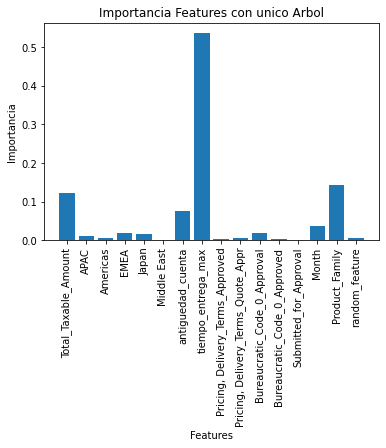

In [275]:
plt.bar(features_list, pipeline.steps[1][1].feature_importances_)
plt.xlabel('Features')
plt.xticks(rotation='vertical')
plt.ylabel('Importancia')
plt.title('Importancia Features con unico Arbol')
plt.show()